In [1]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
file_path = Path.cwd().joinpath("Data", "mpr_data_merged")
output_path = os.path.join(os.path.expanduser("~"), "documents/queensma/ma_essay/data/output")

# NLTK
from nltk.corpus import stopwords

# PLOTTING
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks') # set theme
plt.rc("axes.spines", top=False, right=False) # remove top and right spines for all charts

## GENSIM ##
from gensim.models import Word2Vec
import gensim.downloader as api

# SPACY
import spacy
nlp = spacy.load("en_core_web_lg")

/Users/kelstonchen/miniconda3/envs/nlp/lib/python3.9/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# ORIGINAL DATA USED...
# df = pd.read_csv(file_path.joinpath('mpr_full_R2D.csv'))

# NEW DATA
df = pd.read_csv(file_path.joinpath('data_deep_model_ready_V3.csv'))

# Dictionary Based Method (using Loughran & McDonald dictionary)

In [3]:
# Read Loughran & McDonald's dictionary
lm_df = pd.read_excel(
    Path.cwd().joinpath("Data", "lm_dict.xlsx"), 
    usecols=['Word', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining'])

In [4]:
def create_lm_dict(lm_df):
    """
    This will be used to transform the dataset from Loughran and McDonald 
    into a python dictionary. 
    
    The python dictionary wil be used in the `tone_count_with_negation_check`
    to produce the dictionary features.
    """
    
    # Originally, values were labelled with the year word was added, replace with 1 or 0
    lm_df.loc[:, 'Negative':] = lm_df.loc[:, 'Negative':].applymap(lambda x: 1 if x != 0 else 0)
    # Manipulate data to extract the words for each sentiment category
    temp = pd.melt(
        lm_df, 
        id_vars=['Word']
    ) 
    temp = temp.loc[temp['value'] != 0] # remove uncategorized words
    
    # Create a dictionary to store words
    dictionary = pd.DataFrame(columns=lm_df.columns[1:]).to_dict()
    
    # Extract all words under the following sentiment categories
    for sentiment in lm_df.columns[1:]:
        words = temp[temp['variable'] == sentiment]['Word']
        dictionary[sentiment] = list(words.apply(lambda x: str(x).lower()).values)
    
    return dictionary

In [5]:
lmdict = create_lm_dict(lm_df) # create the dictionary

In [6]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False
    
def tone_count_with_negation_check(dictionary, article):
    """
    Count positive and negative words with negation check. 
    
    Account for simple negation only for positive words.
    
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    
    """
    pos_count = 0
    neg_count = 0
    neu_count = 0
    uncertain_count = 0
    strong_count = 0
    weak_count = 0
    const_count = 0
 
    pos_words = []
    neg_words = []
    neu_words = []
    uncertain_words = []
    strong_words = []
    weak_words = []
    const_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words) # length of sentence
 
    for i in range(0, word_count):
        # Word count for negative words
        if input_words[i] in dictionary['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
            
        # Word count for positive words,
        # includes reversal if negation word is found within 3 words from positive word
        if input_words[i] in dictionary['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
        
        # Supportive sentiment accounting
        if input_words[i] in dictionary['Uncertainty']:
            uncertain_count += 1
            uncertain_words.append(input_words[i])

        if input_words[i] in dictionary['Strong_Modal']:
            strong_count += 1
            strong_words.append(input_words[i])
        
        if input_words[i] in dictionary['Weak_Modal']:
            weak_count += 1
            weak_words.append(input_words[i])
        
        if input_words[i] in dictionary['Constraining']:
            const_count += 1
            const_words.append(input_words[i])
        
        # Neutral word count
        else:
            neu_count += 1
            neu_words.append(input_words[i])
 
    results = [
        word_count, 
        pos_count, 
        neg_count,
        neu_count,
        uncertain_count,
        strong_count,
        weak_count,
        const_count,
        pos_words, 
        neg_words, 
        neu_words,
        uncertain_words,
        strong_words,
        weak_words,
        const_words
    ]
 
    return results

In [7]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]


selected_stopwords = [x for x in stopwords.words('english') if x not in negate]

"""
The code underneath this line is only necessary if the dataset loaded (above) 
does not already contain the features created by the dictionary.
"""

# # Create temporary dataframe
# temp = [tone_count_with_negation_check(lmdict, x) for x in df.text]
# temp = pd.DataFrame(temp)
# temp[8] = temp[8].apply(lambda x: " ".join(x))
# temp[9] = temp[9].apply(lambda x: " ".join(x))
# temp[10] = temp[10].apply(lambda x: " ".join(x))
# temp[11] = temp[11].apply(lambda x: " ".join(x))
# temp[12] = temp[12].apply(lambda x: " ".join(x))
# temp[13] = temp[13].apply(lambda x: " ".join(x))
# temp[14] = temp[14].apply(lambda x: " ".join(x))

# # Word count columns
# df['wordcount'] = temp.iloc[:, 0].values
# df['NPositiveWords'] = temp.iloc[:, 1].values
# df['NNegativeWords'] = temp.iloc[:, 2].values
# df['NNeutralWords'] = temp.iloc[:, 3].values
# df['NUncertainWords'] = temp.iloc[:, 4].values
# df['NStrongWords'] = temp.iloc[:, 5].values
# df['NWeakWords'] = temp.iloc[:, 6].values
# df['NConstWords'] = temp.iloc[:, 7].values

# # Word columns
# df['Poswords'] = temp.iloc[:, 8].values
# df['Negwords'] = temp.iloc[:, 9].values
# df['Neuwords'] = temp.iloc[:, 10].values
# df['Unwords'] = temp.iloc[:, 11].values
# df['Strongwords'] = temp.iloc[:, 12].values
# df['Weakwords'] = temp.iloc[:, 13].values
# df['Conwords'] = temp.iloc[:, 14].values

'\nThe code underneath this line is only necessary if the dataset loaded (above) \ndoes not already contain the features created by the dictionary.\n'

In [8]:
### Export Copy for re-labelling ###
# df.to_csv("mpr_added_dict.csv", index=False)

In [9]:
df.head()

,text,class,mpr,wordcount,NPositiveWords,NNegativeWords,NNeutralWords,NUncertainWords,NStrongWords,NWeakWords,...,Poswords,Negwords,Neuwords,Unwords,Strongwords,Weakwords,Conwords,quarter,year,raw_text
0,Information received since the last Monetary P...,2,2000Q1,41,1,0,41,0,0,0,...,stronger,NaN,information received since the last monetary p...,NaN,NaN,NaN,NaN,1,2000,Information received since the last Monetary P...
1,With the further strengthening of global deman...,2,2000Q1,25,1,0,25,0,0,0,...,strengthening,NaN,with the further strengthening of global deman...,NaN,NaN,NaN,NaN,1,2000,With the further strengthening of global deman...
2,"This has been particularly true for oil, lumbe...",2,2000Q1,18,0,0,17,0,0,0,...,NaN,NaN,this has been particularly true for oil lumber...,NaN,NaN,NaN,constraints,1,2000,"This has been particularly true for oil, lumbe..."
3,Higher crude oil prices have led to higher ene...,0,2000Q1,25,0,0,25,0,0,0,...,NaN,NaN,higher crude oil prices have led to higher ene...,NaN,NaN,NaN,NaN,1,2000,Higher crude oil prices have led to higher ene...
4,"As yet, however, these countries have not seen...",1,2000Q1,26,0,0,26,0,0,0,...,NaN,NaN,as yet however these countries have not seen a...,NaN,NaN,NaN,NaN,1,2000,"As yet, however, these countries have not seen..."


# EDA

In [10]:
top_pos_words = df.Poswords.value_counts()[1:5].index
top_neg_words = df.Negwords.value_counts()[1:].index
top_str_words = df.Strongwords.value_counts()[1:5].index
top_weak_words = df.Weakwords.value_counts()[1:5].index
top_un_words = df.Unwords.value_counts()[1:5].index
top_con_words = df.Conwords.value_counts()[1:5].index

In [11]:
## TOP WORDS BY CATEGORY ##

# pd.DataFrame(
#     {
#         'Positive': top_pos_words,
#         'Negative': top_neg_words,
#         'Strong': top_str_words,
#         'Weak': top_weak_words,
#         'Uncertain': top_un_words,
#         'Constraining': top_con_words
#     }
# ).to_csv(os.path.join(output_path, 'tables', 'top_words.csv'))

mean sentence length: 23 words


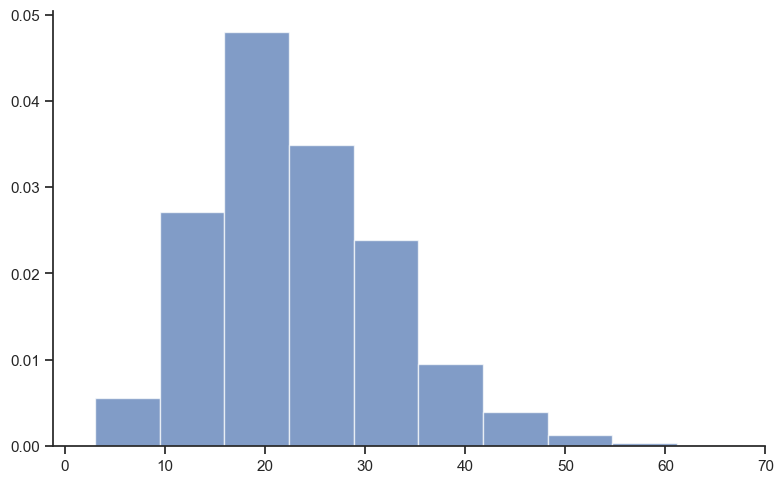

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df['wordcount'], bins=13, alpha=0.7, density=True)
ax.set_xlim(right=70)
plt.tight_layout()

print(f"mean sentence length: {df['wordcount'].mean():.0f} words")

In [13]:
## WORD SUMMARY STATS ##

# (np.round(df[
#     [
#         'wordcount', 
#         'NPositiveWords', 
#         'NNegativeWords', 
#         # 'NNeutralWords', 
#         'NUncertainWords', 
#         'NStrongWords',
#         'NWeakWords',
#         'NConstWords',
#     ]
# ].describe(percentiles=[]), 3).loc[['mean', 'min', 'max']].T).to_csv(os.path.join(output_path, 'tables', 'word_stats.csv'))

In [14]:
# Examples of when negation was used
# for word in df.Negwords.dropna().values:
#     if '(with negation)' in word:
#         print(word)

# Examples of neutral sentences
# df.Neuwords.value_counts()

## Word Cloud

In [15]:
wc_df = pd.read_csv(file_path.joinpath('data_model_ready_V3.csv'))

In [16]:
def join_text(df):
    """
    Combines every sentence into one big string.
    This string will be passed onto WordCloud.
    """
    text = ""
    for i in range(len(df)):
        if df.iloc[i, 0].lower() not in selected_stopwords:
            text += " " + (df.iloc[i, 0]).lower()
    return text.lstrip()

In [17]:
# Join each sentence from the dataframe
# into a big string as input to word cloud
text = join_text(wc_df) 

nlp.max_length = len(text)+1 # Set max length
# Use SpaCy to clean the text
doc = nlp(text)

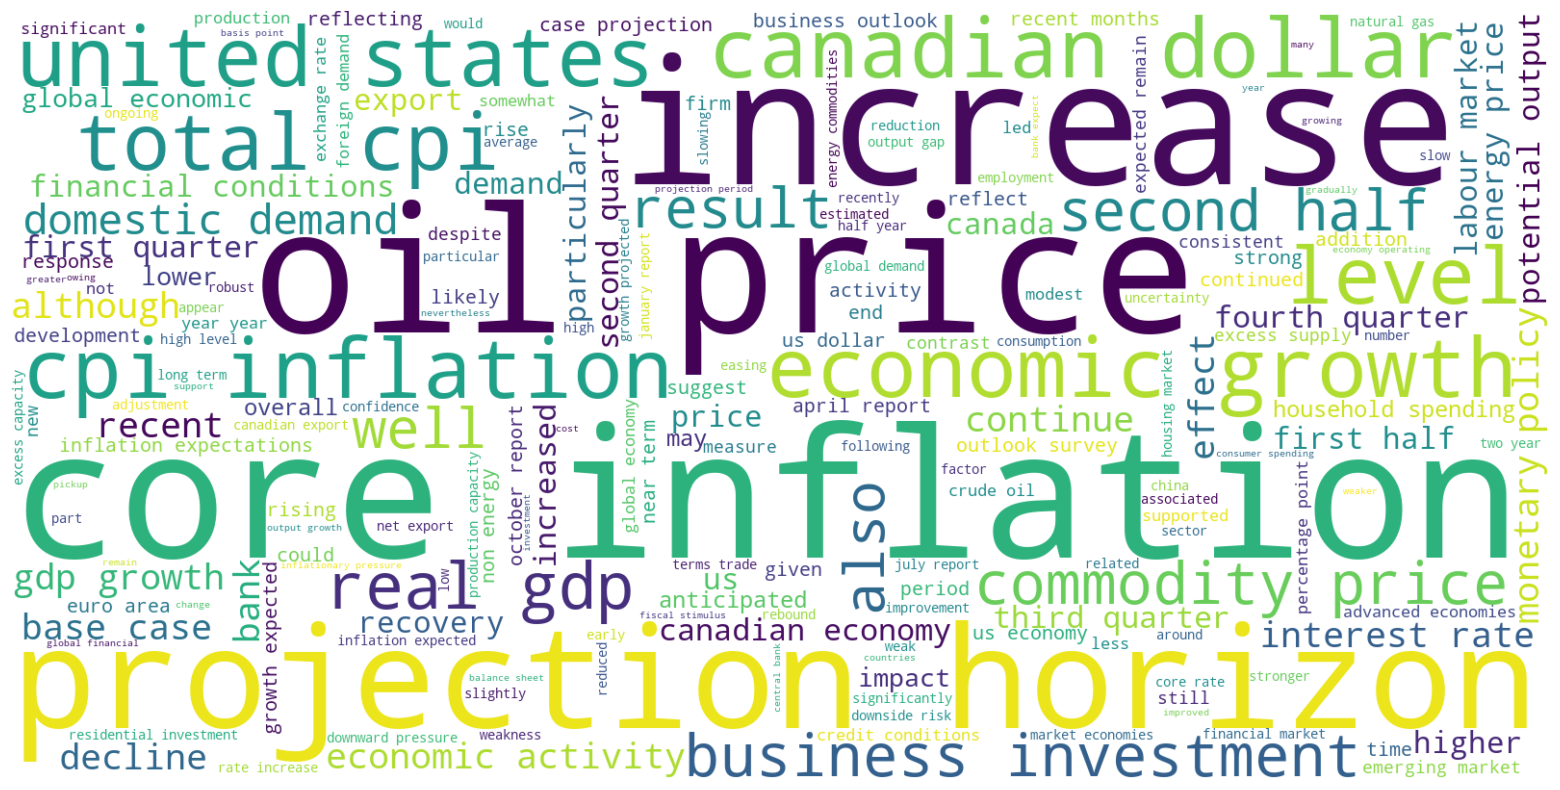

In [18]:
# wordcloud graphic
wc = WordCloud(
    width=1600, 
    height=800,
    background_color="white", 
    repeat=False, 
    mask=None, 
    stopwords=selected_stopwords+['per']+['cent']+['however'],
    random_state=30,
    margin=3, 
    min_word_length=2
)

wc.generate(text)

plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(os.path.join(output_path, 'figures', 'wordcloud.png'), bbox_inches='tight')
plt.show()

# Word Movers Distance (WMD) -- Similarity of MPRs

In [19]:
# Load a pre-trained WMD model that uses Word2Vec trained on google news
# wordvec = api.load('word2vec-google-news-300')

In [20]:
def create_doc(df, year, quarter):
    """
    Concatenate text rows from a selected MPR 
    - one issue of the MPR (quarter and year) - 
    into a single string.
    """
    text = "" # empty text 
    document = df.loc[(df['year'] == year) & (df['quarter'] == quarter), 'text'] # selected MPR
    
    # concat sentences from selected MPR
    for i in document.index:
        text += "".join(document[i])

    return text

def merge_docs(start, end):
    """
    Create and merge MULTIPLE MPR texts together
    
    * `start` and `end` are measured as "years" (ie: 2009, 2010)
    
    * The difference between `start` and `end` must be
    at least 1 year.
    
    Return a text of one or multiple MPR texts.
    """
    doc = ""
    for year in range(start, end):
        for quarter in range(4):
            doc += (create_doc(df, year, quarter+1))
    return doc

def text_to_list(text):
    # Turn a text string into list of strings
    return [w for w in (text).split()]

In [21]:
# # Create docs
# q1_2000 = text_to_list(create_doc(df, 2000, 1))
# q1_2019 = text_to_list(create_doc(df, 2019, 1))
# q1_2005 = text_to_list(create_doc(df, 2005, 1))
# q1_2010 = text_to_list(create_doc(df, 2010, 1))

# Group docs and turn into lists
pre_crisis_1 = text_to_list(merge_docs(2000, 2001))
pre_crisis_2 = text_to_list(merge_docs(2004, 2005))
fin_crisis = text_to_list(merge_docs(2009, 2010))
post_crisis_1 = text_to_list(merge_docs(2014, 2015))
post_crisis_2 = text_to_list(merge_docs(2018, 2019))

In [22]:
## LONG RUN TIME ##
# distances = {
#     "pre crisis to pre crisis": wordvec.wmdistance(pre_crisis_1, pre_crisis_2),
#     "pre crisis to financial crisis": wordvec.wmdistance(pre_crisis_2, fin_crisis),
#     "post crisis to post crisis": wordvec.wmdistance(post_crisis_1, post_crisis_2),
#     "financial crisis to post crisis": wordvec.wmdistance(fin_crisis, post_crisis_2),
#     "pre crisis to post crisis": wordvec.wmdistance(pre_crisis_1, post_crisis_2)
# }

In [23]:
# SAVE AS TABLE
# wmds = pd.DataFrame(distances, index=['WMD']).T
# wmds

In [24]:
# EXPORT TABLE
# wmds.to_csv(os.path.join(output_path, "tables", "WMD_table2.csv"))